## First look on all the data at once

### Doing basic plots for all 10 datasets

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.stattools import durbin_watson

pair_list = [
            ("SHIB-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x811beed0119b4afce20d2583eb608c6f7af1954f", 50),
            ("HEX-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x55d5c232d921b9eaa6b37b5845e439acd04b4dba", 100),
            ("AGIX-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0xe45b4a84e0ad24b8617a489d743c52b84b7acebe", 40),
            ("OPTIMUS-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x8de7a9540e0edb617d78ca5a7c6cc18295fd8bb9", 70),
            ("SHIK-WETH", "https://www.dextools.io/app/en/ether/pair-explorer/0x0b9f5cef1ee41f8cccaa8c3b4c922ab406c980cc", 60),
            ("INJ-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x1bdcebca3b93af70b58c41272aea2231754b23ca", 60),
            ("VOLT-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x487bfe79c55ac32785c66774b597699e092d0cd9", 200),
            ("MBOX-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x8fa59693458289914db0097f5f366d771b7a7c3f", 90),
            ("FLOKI-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0x231d9e7181e8479a8b40930961e93e7ed798542c", 180),
            ("BabyDoge-WBNB", "https://www.dextools.io/app/en/bnb/pair-explorer/0xc736ca3d9b1e90af4230bd8f9626528b3d4e0ee0", 180)
            ]

In [2]:
import pandas as pd

def load_csv_to_df(file_path, verbose=False, name=""):
    # Load CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # If verbose mode is enabled, print the dataset name, number of rows, and some datetime information
    if verbose:
        #print(name)
        print("Number of rows:", len(df))
        print("Last datetime:", df.datetime.iloc[-2], )  # Assuming there is a "datetime" column in the DataFrame
        print("First datetime:", df.datetime.iloc[0])
        print("Time difference (in days):", datetime.strptime(df.datetime.iloc[0], '%Y-%m-%d %H:%M:%S') - datetime.strptime(df.datetime.iloc[-5], '%Y-%m-%d %H:%M:%S'))
        print()
    
    # Return the DataFrame
    return df

def set_index(df, info=False):
    # Convert 'datetime' column to datetime type and set it as the index
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    
    if info:
        # Print some information about the resulting DataFrame
        df.info()

In [3]:
#plotting function
#current version
def plot_price(df, native=True, name="", ax=None, plot_both=False):
    # Choose the column to plot based on native argument
    if native:
        price_column = 'price_native'
        column_name = 'Price (native token)'
    else:
        price_column = 'price_USD'
        column_name = 'Price (USD)'
    
    # Plot the chosen column as a timeseries
    if ax is None and not plot_both:
        fig, ax = plt.subplots(figsize=(12, 6))

    if not plot_both:
        df[price_column].plot(ax=ax)
    
        # Set the title, axis labels
        ax.set_title(f'{name} {column_name} Timeseries')
        ax.set_xlabel('Date')
        ax.set_ylabel(column_name)
    
    # Optionally plot both timeseries side by side
    if plot_both:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        plot_price(df, native=True, name=name, ax=ax1, plot_both=False)
        plot_price(df, native=False, name=name, ax=ax2, plot_both=False)
        plt.show()

In [4]:
#get returns
def add_returns(df, price_col='price_native', ret_col='return', log_ret_col='log_return'):
    """
    Adds returns and log returns columns to a Pandas DataFrame based on a price series.
    
    Parameters:
    df (Pandas DataFrame): The DataFrame to which the columns will be added.
    price_col (str): The name of the column containing the price series (default: 'price').
    ret_col (str): The name of the column to store the simple returns (default: 'return').
    log_ret_col (str): The name of the column to store the log returns (default: 'log_return').
    
    Returns:
    None
    """
    
    # Calculate simple returns
    df[ret_col] = df[price_col].pct_change()
    
    # Calculate log returns
    df[log_ret_col] = np.log(df[price_col] / df[price_col].shift(1))
    
    # Drop the first row (which will have NaN values due to the calculation of returns)
    df.dropna(inplace=True)

In [5]:
def plot_returns(df, native=True, log=True, name = "", lower_percentile=0, higher_percentile=100, histogram = False, bins = 20, 
                 buy_only = False, sell_only = False, set_hist_limit = False, lower_limit_abs = -1, higher_limit_abs = 1):
    """
    Plots the returns or log returns columns of a Pandas DataFrame.
    
    Parameters:
    df (Pandas DataFrame): The DataFrame containing the returns columns to be plotted.
    native (bool): Whether to plot the native currency returns (default: True).
    log (bool): Whether to plot the log returns (default: True).
    
    Returns:
    None
    """
    
    # Choose the columns to plot based on native and log arguments
    if native and log:
        ret_col = 'log_return_native'
        title = 'Log Returns (native token)'
    elif native and not log:
        ret_col = 'return_native'
        title = 'Simple Returns (native token)'
    elif not native and log:
        ret_col = 'log_return_USD'
        title = 'Log Returns (USD)'
    else:
        ret_col = 'return_USD'
        title = 'Simple Returns (USD)'

    # Subset DataFrame based on "buy_order" column if specified
    if buy_only:
        df = df[df["buy_order"] == True]
        title = name + "BUYS " + title
    elif sell_only:
        df = df[df["buy_order"] == False]
        title = name + "SELLS " + title
    else:
        title = name + " " + title

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_data = df[ret_col]
    # lower_limit = np.percentile(plot_data, lower_percentile)*1.1
    # higher_limit = np.percentile(plot_data, higher_percentile)*1.1
    if not histogram:
        lower_limit = np.percentile(plot_data, lower_percentile)*1.1
        higher_limit = np.percentile(plot_data, higher_percentile)*1.1
        plot_data.plot(ax=ax)
        ax.set_ylim(lower_limit, higher_limit)
        # Set the title and axis labels
        ax.set_title(title)
        ax.set_xlabel('Date')
        ax.set_ylabel('Return')
    else:
        plot_data.hist(ax=ax, bins=bins, edgecolor='black')
        if set_hist_limit:
            ax.set_xlim(lower_limit_abs, higher_limit_abs)
        # Set the title and axis labels
        ax.set_title(title)
        ax.set_xlabel('Return')
        ax.set_ylabel('Count')
    
    # Show the plot
    plt.show()


In [6]:
def print_stats(df, native=True, log=True, name = "", quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]):
    """
    Prints the minimum, maximum, and quantiles of a column in a Pandas DataFrame.
    
    Parameters:
    df (Pandas DataFrame): The DataFrame containing the column to be analyzed.
    col (str): The name of the column to be analyzed.
    
    Returns:
    None
    """
    if native and log:
        ret_col = 'log_return_native'
        title = 'Log Returns (native currency)'
    elif native and not log:
        ret_col = 'return_native'
        title = 'Simple Returns (native currency)'
    elif not native and log:
        ret_col = 'log_return_USD'
        title = 'Log Returns (USD)'
    else:
        ret_col = 'return_USD'
        title = 'Simple Returns (USD)'
    print(title)
    print(df[ret_col].min())
    q = df[ret_col].quantile(quantiles)
    print(q)
    print(df[ret_col].max(), "\n")

In [7]:
#Ploting ACF and PACF
def plot_acf_pacf(data, lags=35, figsize=(9, 8)):
    """
    Plots Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for a given time series data.
    
    Args:
    data (array-like): Time series data.
    lags (int): Number of lags to include in ACF and PACF plots. Default is 35.
    figsize (tuple): Figure size of the plots. Default is (9, 8).
    
    Returns:
    None
    """
    f, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    plot_acf(data, lags=lags, ax=ax[0])
    plot_pacf(data, lags=lags, ax=ax[1], method='ols')
    plt.tight_layout()
    plt.show()

In [8]:
#Plot the spacing between observations
def plot_observation_spacing(df, name = ""):
    """
    Plots a histogram of spacing between observations in seconds.
    
    Args:
    - df (pd.DataFrame): Input DataFrame with DateTimeIndex.
    
    Returns:
    - None
    """
    # Calculate spacing between observations
    spacing = np.diff(df.index).astype('timedelta64[s]').astype(int) *-1
    
    # Plot histogram
    plt.hist(spacing, bins=100, edgecolor='black')
    #plt.xlim(0, 20)
    plt.xlabel('Spacing between observations (seconds)')
    plt.ylabel('Frequency')
    plt.title(name + ' Histogram of Spacing between Observations')
    plt.show()

In [9]:
#Get the overview table
def get_overview_table(df, name, column = "return_native", table = None):
    if table is None:
        # Create an empty DataFrame with the specified columns
        table = pd.DataFrame(columns=["name", "observations", "mean", "median", "maximum", "minimum", "skewness", "kurtosis", "jarque_bera", "ADF"])

    # Compute statistics for the given column
    observations = df[column].count()
    mean = df[column].mean()
    median = df[column].median()
    maximum = df[column].max()
    minimum = df[column].min()
    kurtosis = stats.kurtosis(df[column])
    skewness = stats.skew(df[column])
    jarque_bera = stats.jarque_bera(df[column])[0]
    adf = adfuller(df[column])[0]

    # Create a DataFrame for the computed statistics
    stats_df = pd.DataFrame({"name": [name], "observations": [observations], "mean": [mean], "median": [median], "maximum": [maximum],
                             "minimum": [minimum], "kurtosis": [kurtosis], "skewness": [skewness], "jarque_bera": [jarque_bera], "ADF": [adf]})

    # Concatenate the computed statistics DataFrame with the overview table
    table = pd.concat([table, stats_df], ignore_index=True)

    return table

In [10]:
#loop through all 10 datasets
table = None
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    print(name)
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)

    #printing info on column of a df
    #print(df.info())

    ### Basic block of plots ###
    #Price plots
    #plot_price(df, native=True, name=name, ax=None, plot_both=True)
  
    #adding retruns and plotting them
    add_returns(df, price_col='price_native', ret_col='return_native', log_ret_col='log_return_native')
    add_returns(df, price_col='price_USD', ret_col='return_USD', log_ret_col='log_return_USD')
    
    # plot_returns(df, native=True, log=False, name=name, lower_percentile=0, higher_percentile=100, histogram=True, bins=100)
    # plot_returns(df, native=True, log=False, name=name, lower_percentile=0, higher_percentile=100, histogram=False, bins=100)
    # plot_returns(df, native=True, log=False, name=name, lower_percentile=0, higher_percentile=100, histogram=True, bins=100, 
    #              set_hist_limit=False, lower_limit_abs=-0.2, higher_limit_abs=0.2)
    # print_stats(df, native=True, log=False, name=name)
    
    ### Histograms with separate Buy/Sell groups ###
    #adding retruns and plotting them in histogram with buy/sell separated
    # add_returns(df, price_col='price_native', ret_col='return_native', log_ret_col='log_return_native')
    # add_returns(df, price_col='price_USD', ret_col='return_USD', log_ret_col='log_return_USD')
    # plot_returns(df, native=True, log=False, name=name, lower_percentile=0, higher_percentile=100, histogram=True, bins=100, buy_only = False, sell_only = False)
    # plot_returns(df, native=True, log=False, name=name, lower_percentile=0, higher_percentile=100, histogram=True, bins=100, buy_only = True, sell_only = False)
    # plot_returns(df, native=True, log=False, name=name, lower_percentile=0, higher_percentile=100, histogram=True, bins=100, buy_only = False, sell_only = True)


    ### Test Statistics ###
    ##Jarque-Bera test -- H0: Skewness and Kurtosis match Normal distribution - strongly rejected
    # print(stats.jarque_bera(df.return_native))

    ##ADF test (Augment Dickey-Fuller) -- H0: there is a unit root present (i.e. series is not stationary) - strongly rejected
    # result = adfuller(df.return_native)
    # print('ADF Statistic: %f' % result[0], 'p-value: %f' % result[1])

    ##Durbin-Watson test of autocorrelation - H0 no autocorrelation, values around 2, H1 autocorrelation, close to 0 - positive, close to 4 negative
    ##rule of thumb: test statistic values between the range of 1.5 and 2.5 are considered normal
    # print(durbin_watson(df.return_native)) #expect not to reject H0
    # print(durbin_watson(np.abs(df.return_native))) #expect to reject H0 for absolute values of returns - other form of clustering of Realized Variance
    # print("\n")
    
    table = get_overview_table(df, name=name, column = "price_native", table = table)
    
    ### ACF and PACF ###
    #plot_acf_pacf(df.log_return_USD, lags=35, figsize=(9, 8))

    ### Get the histogram of time intervals ###
    #plot_observation_spacing(df, name=name)

print(table)

table.to_csv(r"D:\Dokumenty\Vejška\Magisterské studium\DIPLOMKA\Code_and_Data\Data_scraping\DEX_data_scraper\complete_data\raw_prices_overview.csv", index=False)
    

SHIB-WETH
HEX-WETH
AGIX-WETH
OPTIMUS-WETH
SHIK-WETH
INJ-WBNB
VOLT-WBNB
MBOX-WBNB
FLOKI-WBNB
BabyDoge-WBNB
            name observations          mean        median       maximum  \
0      SHIB-WETH         4754  6.073584e-10  6.064500e-10  7.418000e-10   
1       HEX-WETH        14544  5.227032e-05  5.008000e-05  1.170000e-04   
2      AGIX-WETH         3693  2.733585e-04  2.766000e-04  4.122000e-04   
3   OPTIMUS-WETH         8939  2.290444e-04  2.204000e-04  3.336000e-04   
4      SHIK-WETH         4310  2.355794e-13  2.328000e-13  3.739000e-13   
5       INJ-WBNB         7520  1.371826e-02  1.335000e-02  1.887000e-02   
6      VOLT-WBNB        18006  4.655294e-10  4.495000e-10  5.602000e-10   
7      MBOX-WBNB        12089  1.505814e-03  1.510000e-03  1.568000e-03   
8     FLOKI-WBNB        26364  1.114808e-08  1.111000e-08  1.225000e-08   
9  BabyDoge-WBNB        18441  7.815328e-13  7.686000e-13  8.979000e-13   

        minimum  skewness  kurtosis  jarque_bera       ADF  
0  5.73

In [11]:

def rescale_price_to_time_interval(df, time_interval, price_columns=('price_native', 'price_USD'), rescale_method='close'):
    """
    Rescales price column in a Pandas DataFrame to a specified time interval.

    Args:
        df (pd.DataFrame): Original DataFrame containing price data.
        time_interval (str): Time interval for rescaling. Allowed values are '5Min', '15Min', or '1H' for 5 minutes,
                            15 minutes, or 1 hour, respectively.
        price_column (str, optional): Column name of the price data. Defaults to 'price_native'.
        rescale_method (str, optional): Method for rescaling. Allowed values are 'high', 'low', or 'close' to rescale
                                       to the highest, lowest, or closing price, respectively. Defaults to 'close'.

    Returns:
        pd.DataFrame: Rescaled DataFrame with time intervals and rescaled price column.
    """

    # Resample to desired time interval and select rescale method
    if rescale_method == 'high':
        rescaled_price_native = df[price_columns[0]].resample(time_interval).max()
        rescaled_price_USD = df[price_columns[1]].resample(time_interval).max()
    elif rescale_method == 'low':
        rescaled_price_native = df[price_columns[0]].resample(time_interval).min()
        rescaled_price_USD = df[price_columns[1]].resample(time_interval).min()
    elif rescale_method == 'close':
        rescaled_price_native = df[price_columns[0]].resample(time_interval).last()
        rescaled_price_USD = df[price_columns[1]].resample(time_interval).last()
    else:
        raise ValueError("Invalid rescale_method. Allowed values are 'high', 'low', or 'close'.")

    # Forward fill missing values with last valid value
    rescaled_price_native = rescaled_price_native.ffill()
    rescaled_price_USD = rescaled_price_USD.ffill()

    # Create rescaled DataFrame
    rescaled_df = pd.DataFrame(rescaled_price_native)
    rescaled_df["price_USD"] = rescaled_price_USD

    return rescaled_df

In [12]:
def calculate_realized_variance(df, df_rescaled = None, price_col = "price_native", mode=1, rescale_factor=None, aggregation_period=None):
    """
    Calculate Realized Variance (RV) based on different modes.

    Args:
        prices (pd.Series): Series of prices with datetime index.
        returns (pd.Series, optional): Series of returns. If not provided, it will be calculated from prices. 
                                       Default is None.
        mode (int, optional): Mode to calculate RV. 
                               1 - Calculate RV on base price data, disregarding rescaling.
                               2 - Calculate RV on base price data, disregarding rescaling, 
                                   but divide it by a number of observations in each block.
                               3 - Sum returns over longer periods based on 5-min aggregated returns. 
                                   Default is 1.
        rescale_factor (int or None, optional): Rescaling factor for price data. 
                                                Required for mode 1 and mode 2. Default is None.
        aggregation_period (str or None, optional): Aggregation period for returns. 
                                                     Required for mode 3. Default is None.

    Returns:
        Dataframe with Realized Variance
    """
    if mode == 1:
        # Calculate simple returns
        df["return_native"] = df[price_col].pct_change()        
        rv = (df["return_native"]**2).resample("5Min").sum()

    elif mode == 2:
        df["return_native"] = df[price_col].pct_change()    
        count = df["return_native"].resample("5Min").count()
        count = count.replace(0, 1)    
        rv = (df["return_native"]**2).resample("5Min").sum()/count

    elif mode == 3:
        rv = (df_rescaled["return_native"]**2).resample("1H").sum()
    else:
        raise ValueError("Invalid mode value. Please select mode 1, mode 2, or mode 3.")

    return rv

In [13]:
#loop through all 10 datasets
table = None
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    print(name)
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)

    df_rescaled = rescale_price_to_time_interval(df,time_interval = "5Min", rescale_method='close')

    #print(df_rescaled.info())

    #Price plots
    #plot_price(df_rescaled, native=True, name=name, ax=None, plot_both=True)
  
    #adding retruns and plotting them
    add_returns(df_rescaled, price_col='price_native', ret_col='return_native', log_ret_col='log_return_native')
    add_returns(df_rescaled, price_col='price_USD', ret_col='return_USD', log_ret_col='log_return_USD')
    
    # #plot_returns(df, native=True, log=False, name=name, lower_percentile=0, higher_percentile=100, histogram=True, bins=100)
    # plot_returns(df_rescaled, native=True, log=False, name=name, lower_percentile=0, higher_percentile=100, histogram=False, bins=100)
    # plot_returns(df_rescaled, native=True, log=False, name=name, lower_percentile=0, higher_percentile=100, histogram=True, bins=100)
    # print_stats(df_rescaled, native=True, log=False, name=name)



    ####################Test Statistics
    #print Jarque-Bera test -- H0: Skewness and Kurtosis match Normal distribution - strongly rejected
    # print(stats.jarque_bera(df_rescaled.return_native))

    #print ADF (Augment Dickey-Fuller) -- H0: there is a unit root present (i.e. series is not stationary) - strongly rejected
    # result = adfuller(df_rescaled.return_native)
    # print('ADF Statistic: %f' % result[0], 'p-value: %f' % result[1])

    ##Durbin-Watson test of autocorrelation - H0 no autocorrelation, values around 2, H1 autocorrelation, close to 0 - positive, close to 4 negative
    ##rule of thumb: test statistic values between the range of 1.5 and 2.5 are considered normal
    # print(durbin_watson(df_rescaled.return_native)) #expect not to reject H0
    # print(durbin_watson(np.abs(df_rescaled.return_native))) #expect to reject H0 for absolute values of returns - other form of clustering of Realized Variance
    # print("\n")

    table = get_overview_table(df_rescaled, name=name, column = "return_native", table = table)


    ##############ACF and PACF
    #plot_acf_pacf(df_rescaled.return_native, lags=35, figsize=(9, 8))


    ### Calculate RV
    # rv_1 = calculate_realized_variance(df = df, df_rescaled = df_rescaled, price_col = "price_native", mode=1)
    # rv_2 = calculate_realized_variance(df = df, df_rescaled = df_rescaled, price_col = "price_native", mode=2)
    # rv_3 = calculate_realized_variance(df = df, df_rescaled = df_rescaled, price_col = "price_native", mode=3)
    # # print(rv)
    # # rv.plot()
    # # plt.show()

    # # Create subplots with 1 row and 3 columns
    # fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # # Plot rv_1 on the first subplot
    # rv_1.plot(ax=axes[0])
    # axes[0].set_title('RV_mode_1')

    # # Plot rv_2 on the second subplot
    # rv_2.plot(ax=axes[1])
    # axes[1].set_title('RV_mode_2')

    # # Plot rv_3 on the third subplot
    # rv_3.plot(ax=axes[2])
    # axes[2].set_title('RV_mode_3')

    # # Set the overall title for the plot
    # plt.suptitle(name + ' Realized Variance')

    # # Display the plot
    # plt.show()

    # #Printing the DW test: close to 2 - no autocorrelation, outside of (1.5, 2.5) - autocorrelation
    # #The square root is the Realized Volatility -- this should be autocorrelated acording to my text
    # print("mode_1: ", durbin_watson(rv_1), "sqrt: ", durbin_watson(np.sqrt(rv_1)))
    # print("mode_2: ", durbin_watson(rv_2), "sqrt: ", durbin_watson(np.sqrt(rv_2)))
    # print("mode_3: ", durbin_watson(rv_3), "sqrt: ", durbin_watson(np.sqrt(rv_3)))

print(table)    
table.to_csv(r"D:\Dokumenty\Vejška\Magisterské studium\DIPLOMKA\Code_and_Data\Data_scraping\DEX_data_scraper\complete_data\returns_5min.csv", index=False)

SHIB-WETH
HEX-WETH
AGIX-WETH
OPTIMUS-WETH
SHIK-WETH
INJ-WBNB
VOLT-WBNB
MBOX-WBNB
FLOKI-WBNB
BabyDoge-WBNB
            name observations          mean    median   maximum   minimum  \
0      SHIB-WETH         5208 -9.094539e-07  0.000000  0.030364 -0.025481   
1       HEX-WETH         4991  5.607362e-05  0.000199  0.261426 -0.202094   
2      AGIX-WETH         5416 -4.846103e-05  0.000000  0.034690 -0.043198   
3   OPTIMUS-WETH         4964  2.313354e-06  0.000000  0.154196 -0.081216   
4      SHIK-WETH         5329 -4.358089e-05  0.000000  0.141626 -0.112736   
5       INJ-WBNB         5210  4.318333e-05  0.000000  0.050223 -0.030351   
6      VOLT-WBNB         4715 -3.890263e-05  0.000000  0.025437 -0.040886   
7      MBOX-WBNB         4552 -2.042600e-06  0.000000  0.021206 -0.011170   
8     FLOKI-WBNB         4388 -7.053557e-06  0.000000  0.024150 -0.042940   
9  BabyDoge-WBNB         4594  2.965869e-05  0.000000  0.058492 -0.022052   

   skewness    kurtosis   jarque_bera        A

SHIB-WETH
HEX-WETH
AGIX-WETH
OPTIMUS-WETH
SHIK-WETH
INJ-WBNB
VOLT-WBNB
MBOX-WBNB
FLOKI-WBNB
BabyDoge-WBNB


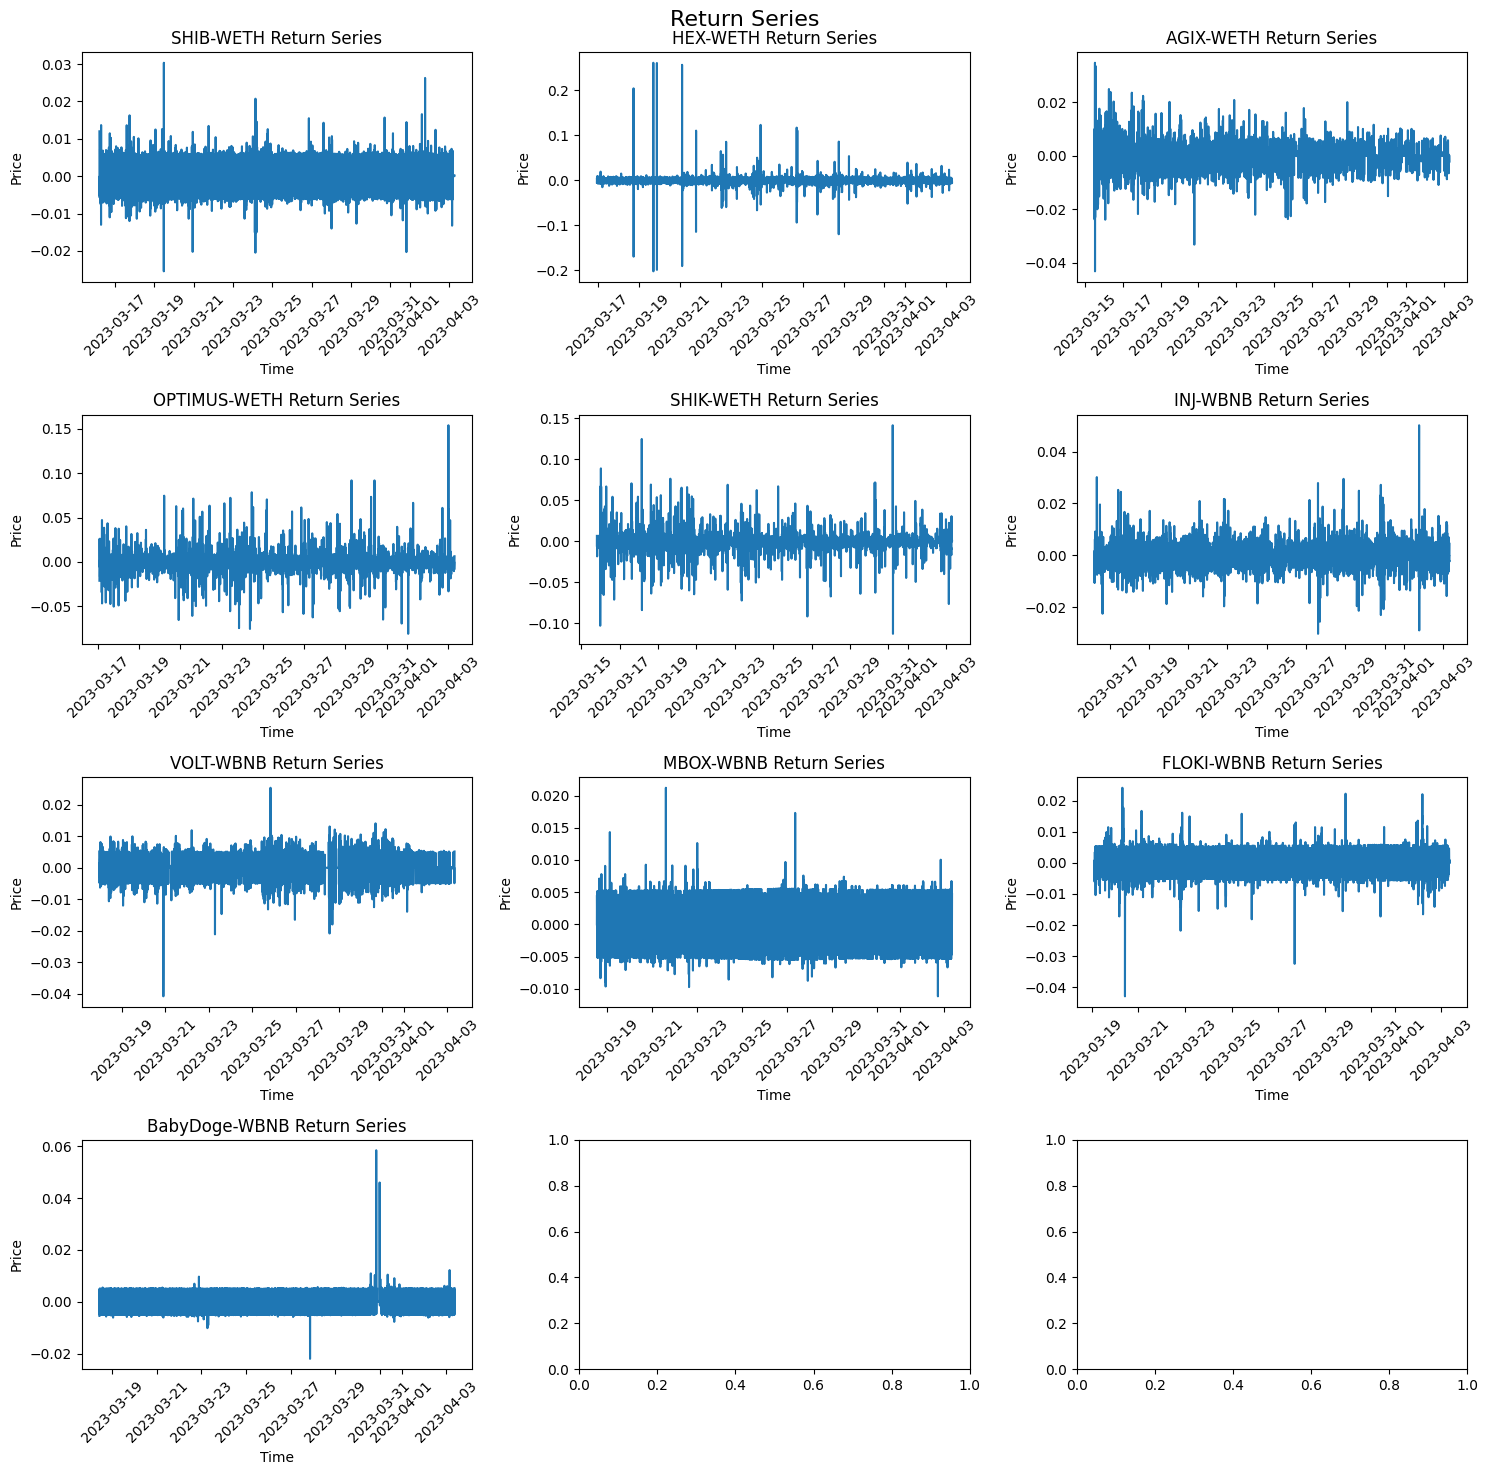

In [14]:
#plot 10 price series or 10 returns
# Create a 4x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.suptitle('Return Series', fontsize=16)

# Loop through each .csv file and plot on the corresponding subplot
i=0
for pair in pair_list:
    #geting name of current pair and folder location
    name = pair[0]
    print(name)
    file_path = f"D:/Dokumenty/Vejška/Magisterské studium/DIPLOMKA/Code_and_Data/Data_scraping/DEX_data_scraper/complete_data/{name}/{name}_complete.csv"

    #loading data without werbose printout, seting index
    df = load_csv_to_df(file_path, verbose=False, name = name)
    set_index(df, info=False)

    df_rescaled = rescale_price_to_time_interval(df,time_interval = "5Min", rescale_method='close')
    add_returns(df_rescaled, price_col='price_native', ret_col='return_native', log_ret_col='log_return_native')
    add_returns(df_rescaled, price_col='price_USD', ret_col='return_USD', log_ret_col='log_return_USD')
    
    # Extract the plotted series
    plotted_series = df_rescaled['return_native']
    
    # Compute the row and column index of the subplot
    row_idx = i // 3
    col_idx = i % 3
    
    # Plot the price series on the subplot
    axes[row_idx, col_idx].plot(plotted_series)
    #axes[row_idx, col_idx].xticks(rotation=45)
    axes[row_idx, col_idx].tick_params(axis='x', rotation=45)
    axes[row_idx, col_idx].set_title(f'{name} Return Series')
    axes[row_idx, col_idx].set_xlabel('Time')
    axes[row_idx, col_idx].set_ylabel('Price')

    i+=1

# Add padding between subplots
plt.tight_layout()

# Display the plot
plt.show()

### Ideas

#### 4/10/23

What I see as a problems right now:

- I have unevenly spaced trade data.

- Returns I see are sometimes as expected, sometimes there is the buy-sell (spread) gap.

Solutions:

- spacing: Transform data to unified time intervals. Either 5 minutes, or play along with the blockchain timing and set interval 12 sec on ETH and 3 on BSC -- verify with the histogram of time interval lenghts. The reason is that my focus is now just describe how returns behave, not some fancy durations stuf. This Would give me a solid base how the returns could be described and I could continue to the *simulation*.

- Spread gap: Either transform data somehow, or leave as "feature", not a bug", and attempt to simulate it in the Agent model

ToDo next:

- ~~Plot the histogram of observation spacings~~ -- done, they are mostly close to sub 1 minute (majority between 0 and 50 seconds). It seems that it might be reasonable to set the rescale time interval according to blocks, in ETH a lot of trades is spaced between 8 and 15 seconds, while in BSC it is sub 8 (rough estinates, just based on histogram observations). This aligns with the blocktimes.

- ~~Try rescaling data with 12 and 3 second intervals~~ -- tried 12s and it seems like too much, at least for histograms. The plots of prices and returns in time look very similar, in histogram any other values than 0 have almost no bars. The 3 seconds very similar.

- ~~get the Jarque berra test and ADF test for 5Min transformation, just to verify that it is sound~~ -- it is, super significantly both rejected

- ~~Plot ACF and PACF ((partial)autocorrelation function) - read the kaggle post + define it as a function~~ -- done


#### 4/11/23

What have I done:

- I have done the TODOs from yesterday. 
 
  * I have played with the ACF and PACF, but later realized I might not need them. I am not sure yet.
  * Rescaling for respective blocktimes -- this seems like too small interval. Probably will stick to 5Min. Although from histogram of observation spaces it seemed like it would be sound, as there are many observation spaced out roughly by the blocktime.
- I further analyzed returns - Durbin-Watson test for autocorrelation of returns and absolute returns. It moreless fits the stylized facts, small deviation.

What I see as a problems right now:

- I would like to move to either Describing analyzis of returns in DP text or to simulation. For that I need to answer the two problems I see:
  * Unevenly spaced data, is 5 minute aggregation good idea
  * The spread gap on some pairs -- I still have no idea what to do with this

Solutions:

- Write email to LK asap. Tomorow? Perhaps no need for consultation if I describe what I think I should do and LK agrees? Before sending email remains to do the table as in the paper.

ToDo next:
- ~~Add method for calculating realized variance~~ -- only possible for aggregated data from definition? - clarify!
  * Notes from research on this: RV is calculated as a sum of returns over some time period. Thus, the unevenly spaced observations could affect this, as more transactions would lead to cumulation of returns at certain points (*but isnt that interesting as well??*). 
  * ~~Try these three options:~~ -- done
    * Do the five minute interval and sum the returns, no special treatment
    * Sum returns over five minute intervals and divide the sum by number of observations summed
    * Sum returns over longer periods (1 hour?), based on 5-min aggregated returns
- ~~Add the DW test for Realized Variance~~
- ~~Do the overview table~~
- Clarify whether ACF and PACF will be useful (perhaps in analyzing the GARCH effects in returns??)

#### 4/12/23

What have I done:

- I have done the Overview Tables following the example from the paper
- I have done the Realized Variance in three ways

ToDo tommorow:
- ~~Add to the overview table n of obs~~
- ~~Interpret the results of RV, run it through the DW test~~
- ~~Check for other rests. Perhaps do the aggregated figure.~~
- ~~Write email to LK.~~

#### 4/13/23

What have I done:

- Added Observations column to Overview table
- Looked one more time into the spread gap. It seems like there is a hidden constant by which the price changes when the "sentiment" changes.
- I have done plots and DW test for all three modes of Realized Variance
    - From the plots, the mode 3 (Calculating RV based on aggregated prices and returns, as metaaggreagetion 5 min -> 1 hour), looks best, I will probably stick to this mode.
    - Also the third mode has the best results on autocorrelation of Realized Volatility (sqrt of Realized Variance) -- all are autocorrelated, even HEX.
    - The other methods mostly also ok, but mode 3 has the highest autocorrelation and the plots look as expected the most.
- Went through the last meeting notes.
- Wrote email to LK and asked for meeting

#### 4/13/23

What have I done:

In [16]:
#testing how to plot figures nicer
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9
